In [3]:
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from math import sqrt
#----------------------------------------------

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from optparse import OptionParser
from tqdm import tqdm

In [4]:
def standardization(X):
    return normalize(X, axis=0)

In [5]:
def laplacian(A):
    S = np.sum(A, 0)
    D = np.diag(S)
    D = LA.matrix_power(D, -1)
    L = np.dot(D, A)
    return L

In [6]:
def normalization(V):
    return (V - min(V)) / (max(V) - min(V))

In [7]:
class Correlation_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'correlation')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [8]:
class Cosine_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'cosine')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [9]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [11]:
from google.colab import drive

#drive.mount('/content/drive')

In [12]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_topics_set2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern


In [ ]:
#df.dropna(subset=['content'], inplace = True)
#df.dropna(subset=['topic'], inplace = True)
#df['your column name'].isnull().values.any()

In [ ]:
#len(df.content.unique()),  len(df.content), len(df.topic)

In [ ]:
#df.isnull().sum()

In [ ]:
df.shape

(2155, 7)

In [ ]:
np.unique(df.processed_topic[:600]).shape[0]

20

In [ ]:
#import re

#import gensim
#from gensim import corpora,models
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel
#from gensim.parsing.preprocessing import STOPWORDS
#from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem.porter import *
#import numpy as np
#np.random.seed(2018)

#import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')

In [ ]:
#stemmer = SnowballStemmer(language='english',ignore_stopwords=True)
#def lemmatize_stemming(text):
#    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
#def preprocess(text):
    #result = []
   # for token in gensim.utils.simple_preprocess(text):
   #     if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
   #         result.append(lemmatize_stemming(token))
  #  return result

In [ ]:
#doc_sample = df['content'][0]
#print('original document: ')
#words = []
#for word in doc_sample.split(' '):
#    words.append(word)
#print(words)
#print('\n\n tokenized and lemmatized document: ')
#print(preprocess(doc_sample))

In [ ]:
#df['processed_heading'] = df['heading'].map(preprocess)
#df['processed_content'] = df['content'].map(preprocess)
#df['processed_topic'] = df['topic'].map(preprocess)
#df['processed_heading'] = df['processed_heading'].apply(lambda x: ' '.join(x))
#df['processed_content'] = df['processed_content'].apply(lambda x: ' '.join(x))
#df['processed_topic'] = df['processed_topic'].apply(lambda x: ' '.join(x))
#df.head()

In [ ]:
#df.to_csv('/content/drive/My Drive/edited_all_news.csv')

In [ ]:
#from collections import Counter
#Counter(df.topic[700:])

In [13]:
y1 = pd.factorize(df.processed_topic)[0]
y1

array([0, 1, 0, ..., 7, 1, 1])

In [14]:
def read_NewsGroup_data(similarity):    
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    op = OptionParser()
    op.add_option("--lsa", dest="n_components", type="int",
                  help="Preprocess documents with latent semantic analysis.")    
    op.add_option("--no-idf",action="store_false", dest="use_idf", default=True,
                  help="Disable Inverse Document Frequency feature weighting.")
    op.add_option("--use-hashing", action="store_true", default=False,
                  help="Use a hashing feature vectorizer")
    op.add_option("--n-features", type=int, default=10000,
                  help="Maximum number of features to extract from text.")    
    def is_interactive():
        return not hasattr(sys.modules['__main__'], '__file__')
    argv = [] if is_interactive() else sys.argv[1:]
    (opts, args) = op.parse_args(argv)
    if len(args) > 0:
        op.error("this script takes no arguments.")
        sys.exit(1)
        
    labels = y1
    data = df.processed_content
    #true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_features=opts.n_features,use_idf=opts.use_idf)
    X = vectorizer.fit_transform(data)
    if opts.n_components:
        svd = TruncatedSVD(opts.n_components)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X = lsa.fit_transform(X)
        explained_variance = svd.explained_variance_ratio_.sum()
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

In [15]:
# Call Correlation_Similarity as similarity dataset.
trainSet_correlation = read_NewsGroup_data(Correlation_Similarity())

In [16]:
# Call Cosine_Similarity as similarity dataset.
trainSet_cosine = read_NewsGroup_data(Cosine_Similarity())

In [17]:
n_input = trainSet_correlation.data_size #--------- Number of input data.
# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_hidden_2 = int(n_hidden_1/2) #------------ The autoencoder hidden layer 2.
n_hidden_3 = int(n_hidden_2/2) #------------ The autoencoder hidden layer 3.
n_code = str(2) #--------------------------- The number of output dimension value.

print('Layer 1: -----------', n_input)
print('Layer 2: -----------', n_hidden_1)
print('Layer 3: -----------', n_hidden_2)
print('Layer 4: -----------', n_hidden_3)
print('Layer 5: -----------', int(n_code))

Layer 1: ----------- 2155
Layer 2: ----------- 1024
Layer 3: ----------- 512
Layer 4: ----------- 256
Layer 5: ----------- 2


In [18]:
def k_means_(X, n_clusters):
    kmeans_centroids,_ =  kmeans(X, n_clusters)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [19]:
def encoder(x, n_code, mode_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("hidden-layer-2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], mode_train)
        with tf.variable_scope("hidden-layer-3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], mode_train)        
        with tf.variable_scope("embedded"):
            code = layer(hidden_3, [n_hidden_3, n_code], [n_code], mode_train)
    return code

def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(code, [n_code, n_hidden_3], [n_hidden_3], mode_train)
        with tf.variable_scope("hidden-layer-2"):
            hidden_2 = layer(hidden_1, [n_hidden_3, n_hidden_2], [n_hidden_2], mode_train)
        with tf.variable_scope("hidden-layer-3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_1], [n_hidden_1], mode_train)              
        with tf.variable_scope("reconstructed"):
            output = layer(hidden_3, [n_hidden_1, n_input], [n_input], mode_train)
    return output

In [20]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-08, True)
    return tf.reshape(normed, [-1, n_out])

def layer(input, weight_shape, bias_shape, mode_train):
    value_initialize = (1.0 / weight_shape[0] ** 0.5)
    weight_initialize = tf.random_normal_initializer(stddev = value_initialize, seed = None)
    bias_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    w = tf.get_variable("w", weight_shape, initializer=weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer=bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

def loss(reconstructed, x):
    with tf.variable_scope("train"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
        return train_loss

In [21]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op



In [35]:
# Parameters
n_layers = (5*2)*2 #------------------------ Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------- The decay rate 1.  
beta2 = 0.999 #----------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #----------- The learning rate.
#n_batch = math.ceil(sqrt(sqrt(n_input))) #-- Number of selection data in per step.
n_batch = 32
n_backpro = math.ceil(n_input/n_batch) #---- Number of Backpro in per epoch.
n_clusters = 30 #---------------------------- Number of clusters.
n_diplay = 4 #------------------------------ Number of getting code and runnig the K-Means.

data_cor, labels_cor = trainSet_correlation.whole_dataset() #-- Allocation of data and labels
data_cos, labels_cos = trainSet_cosine.whole_dataset() #------- Allocation of data and labels

results_cor=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cor=[] #------------------------- A list to keep all training evaluations.
steps_cor=[] #----------------------------- A list to keep all steps.


In [36]:
seeding_cor = []

In [37]:
print(n_batch)

32


In [38]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [39]:
# Training cycle
epoch = 0
while epoch == 0 or epoch < n_layers:
    # Fit training with Backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = trainSet_correlation.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                  mode_train:True})       
    #------------------------- End of the Optimization ------------------------------
    epoch += 1
    # Save the results after per 10 epochs.    
    if epoch % n_diplay == 0 or epoch >= n_layers:
        # Getting embedded codes and running K-Means on them.
        ae_codes_cor = sess.run(code, feed_dict={x: data_cor, mode_train: False})        
        idx_cor = k_means_(ae_codes_cor, n_clusters)
        ae_nmi_cor = normalized_mutual_info_score(labels_cor, idx_cor)
        ae_nmi_cor = ae_nmi_cor*100
        results_cor.append(ae_nmi_cor)    
        steps_cor.append(epoch)
        loss_cost_cor.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi_cor, new_cost, epoch))

NMI Score for AE is: 28.02 and new cost is: 408.60 in 4 step. 
NMI Score for AE is: 27.25 and new cost is: 359.78 in 8 step. 
NMI Score for AE is: 27.32 and new cost is: 317.66 in 12 step. 
NMI Score for AE is: 27.04 and new cost is: 281.16 in 16 step. 
NMI Score for AE is: 26.15 and new cost is: 245.62 in 20 step. 


In [40]:
print("The Average of NMI Score for >>> {:d} <<< Random Factors in Autoencoder Correlation is >>> {:0.2f} <<<"
      .format(20, (np.mean(results_cor))))

The Average of NMI Score for >>> 20 <<< Random Factors in Autoencoder Correlation is >>> 27.16 <<<


In [41]:
results_cor

[28.02423348895498,
 27.25461201948114,
 27.323338161939432,
 27.03544636410649,
 26.149166833925957]

In [42]:
results_cos=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cos=[] #------------------------- A list to keep all training evaluations.
steps_cos=[] #----------------------------- A list to keep all steps.

with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [43]:
#training cycle

epoch = 0
while epoch == 0 or epoch < n_layers:
    # Fit training with backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = trainSet_cosine.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                  mode_train: True})       
    #------------------------- End of the Optimization ------------------------------
    epoch += 1
    # Save the results after per 10 epochs.    
    if epoch % n_diplay == 0 or epoch >= n_layers:
        # Getting embedded codes and running K-Means on them.
        ae_codes_cos = sess.run(code, feed_dict={x: data_cos, mode_train: False})        
        idx_cos = k_means_(ae_codes_cos, n_clusters)
        ae_nmi_cos = normalized_mutual_info_score(labels_cos, idx_cos)
        ae_nmi_cos = ae_nmi_cos*100
        results_cos.append(ae_nmi_cos)    
        steps_cos.append(epoch)
        loss_cost_cos.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi_cos, new_cost, epoch))

NMI Score for AE is: 25.51 and new cost is: 412.38 in 4 step. 
NMI Score for AE is: 24.89 and new cost is: 363.60 in 8 step. 
NMI Score for AE is: 24.40 and new cost is: 320.03 in 12 step. 
NMI Score for AE is: 24.73 and new cost is: 283.31 in 16 step. 
NMI Score for AE is: 24.27 and new cost is: 248.85 in 20 step. 


In [44]:
print("The Average of NMI Score for >>> {:d} <<< Random Factors in Autoencoder Cosine is >>> {:0.2f} <<<"
      .format(len(seeding_cos), (np.mean(results_cos))))

NameError: ignored

In [ ]:
results_cos

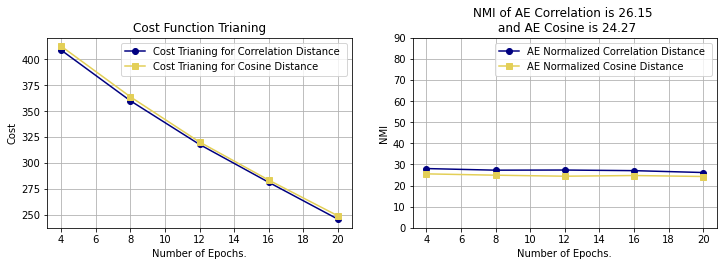

In [45]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
plt.plot(steps_cor, loss_cost_cor, label='Cost Trianing for Correlation Distance ', color='#000080', marker='o')
plt.plot(steps_cos, loss_cost_cos, label='Cost Trianing for Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('Cost')
plt.grid()
plt.title('Cost Function Trianing')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.ylim(0, 90)
plt.plot(steps_cor, results_cor, label='AE Normalized Correlation Distance ', color='#000080', marker='o')
plt.plot(steps_cos, results_cos, label='AE Normalized Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE Correlation is {:0.2f} \n and AE Cosine is {:0.2f}').format(ae_nmi_cor, ae_nmi_cos))
plt.legend(loc='best')
plt.show()

In [54]:
color = ['k','r','forestgreen','g','blue','gray',
                'cyan','goldenrod','goldenrod','gray','purple','greenyellow',
                'grey','honeydew','hotpink','indianred','y', 'k', 'pink', 'blue', 'violet', 'brown', 'grey', 'y', 'navy']
markers_list = ["o","v","*","8","h","p"] * 5


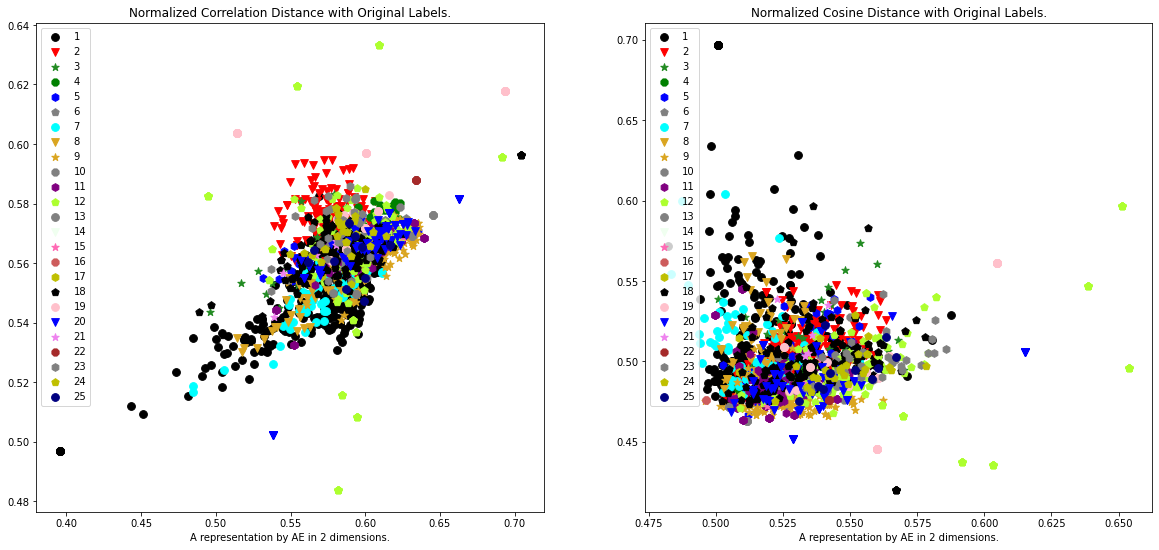

In [57]:
origin_label_cos = np.array(trainSet_cosine.whole_dataset()[1]).astype(int)
origin_label_cor = np.array(trainSet_correlation.whole_dataset()[1]).astype(int)
plt.figure(figsize=(20, 9))
for num in range(25):
    plt.subplot(1,2,1)
    plt.scatter([ae_codes_cor[:,0][i] for i in range(len(origin_label_cor)) if origin_label_cor[i] == num],
                [ae_codes_cor[:,1][i] for i in range(len(origin_label_cor)) if origin_label_cor[i] == num],
                60, label=str(num+1), color = color[num], marker=markers_list[num])
    plt.title('Normalized Correlation Distance with Original Labels.')
    plt.xlabel('A representation by AE in 2 dimensions.')
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                60, label=str(num+1), color = color[num], marker=markers_list[num])
    plt.title('Normalized Cosine Distance with Original Labels.')
    plt.xlabel('A representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

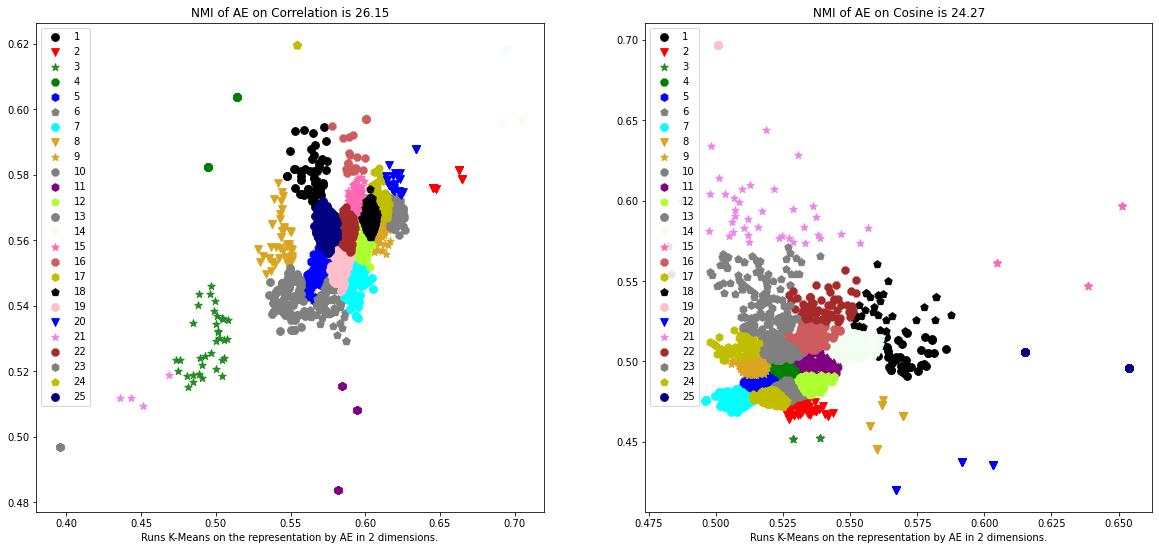

In [58]:

plt.figure(figsize=(20, 9))
for num in range(25):
    plt.subplot(1,2,1)
    plt.scatter([ae_codes_cor[:,0][i] for i in range(len(idx_cor)) if idx_cor[i] == num],
                [ae_codes_cor[:,1][i] for i in range(len(idx_cor)) if idx_cor[i] == num],
                60, label=str(num+1), color = color[num], marker=markers_list[num])
    plt.title(('NMI of AE on Correlation is {:0.2f}').format(ae_nmi_cor))
    plt.xlabel('Runs K-Means on the representation by AE in 2 dimensions.')
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                60, label=str(num+1), color = color[num], marker=markers_list[num])
    plt.title(('NMI of AE on Cosine is {:0.2f}').format(ae_nmi_cos))
    plt.xlabel('Runs K-Means on the representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

In [59]:
print("Autoencoder Clustering on Cosine: ------------ {:0.2f}".format(ae_nmi_cos))
print("Autoencoder Clustering on Correlation: ------- {:0.2f}".format(ae_nmi_cor))


Autoencoder Clustering on Cosine: ------------ 24.27
Autoencoder Clustering on Correlation: ------- 26.15


In [60]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
features = vec.transform(df.processed_content.values)

In [63]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(features.toarray(),idx_cor, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  39.559 %
     Precision:  51.519 %
        Recall:  50.605 %
      F1 score:  50.447 %


In [65]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  27.842 %
     Precision:  38.803 %
        Recall:  36.785 %
      F1 score:  35.314 %


In [66]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(features.toarray(),idx_cos, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  34.455 %
     Precision:  46.701 %
        Recall:  45.727 %
      F1 score:  45.307 %


In [68]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  17.633 %
     Precision:  23.474 %
        Recall:  23.487 %
      F1 score:  20.745 %


In [69]:
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (features, idx_cor, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 30, Kmeans silhouette score is 0.0032561528280619736)


In [73]:
data_all = df.copy()

data_all['cluster_cor'] = idx_cor
data_all.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,cluster_cor
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,28
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,26
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,29
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,29
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,24


In [74]:
data_all = data_all.copy()

data_all['cluster_cos'] = idx_cos
data_all.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,cluster_cor,cluster_cos
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,28,5
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,26,10
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,29,15
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,29,22
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,24,13


In [75]:
#data_all.to_csv('/content/drive/My Drive/saman_nia_cluster_low_gamma.csv')

In [76]:
data_all['cluster_cor'].value_counts()

21    167
9     148
11    144
17    141
24    130
16    129
18    127
6     117
26    115
4      96
14     96
8      87
12     86
25     82
29     77
5      64
28     62
0      53
7      46
19     35
2      35
15     23
13     21
10     19
1      16
3      14
27      7
22      7
23      7
20      4
Name: cluster_cor, dtype: int64

In [77]:
data_all['cluster_cos'].value_counts()

4     169
3     142
8     128
10    127
23    124
12    117
11    109
27     97
15     90
29     88
9      87
26     84
13     80
28     77
22     75
6      70
1      64
5      64
16     62
21     61
0      41
20     38
25     33
17     32
7      23
14     21
19     21
24     14
2      10
18      7
Name: cluster_cos, dtype: int64

topic modelling

In [78]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
#First we will create 20 vectorizers, one for each of our cluster labels

vectorizers = []
    
for ii in range(0, 25):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(stop_words='english'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [83]:
#Now we will vectorize the data from each of our clusters

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(data_all.loc[data_all.cluster_cor == current_cluster, 'processed_content']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
len(vectorized_data)

#number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 25):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [84]:
#For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
        
#Extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [85]:
#Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
all_keywords[3][:10]

['india',
 'lockdown',
 'test',
 'govern',
 'data',
 'user',
 'research',
 'app',
 'time',
 'studi']

In [86]:
#lda

for i in range(0,25):
  print(all_keywords[i][:10])

['invest', 'huawei', 'msmes', 'crore', 'singh', 'govern', 'need', 'indigo', 'fiscal', 'bank']
['wildlif', 'cake', 'film', 'jungl', 'say', 'hous', 'bake', 'ingredi', 'baker', 'stoneham']
['cent', 'report', 'test', 'juli', 'oxygen', 'saturday', 'home', 'capit', 'friday', 'sunday']
['india', 'lockdown', 'test', 'govern', 'data', 'user', 'research', 'app', 'time', 'studi']
['say', 'covid', 'school', 'result', 'state', 'court', 'board', 'colleg', 'test', 'immun']
['court', 'vika', 'parti', 'governor', 'case', 'hospit', 'result', 'juli', 'karnataka', 'pakistan']
['congress', 'court', 'case', 'joshi', 'dubey', 'kanpur', 'encount', 'singh', 'villag', 'prakash']
['taiwan', 'india', 'lockdown', 'student', 'mask', 'countri', 'case', 'vaccin', 'virus', 'onlin']
['suresh', 'say', 'spirit', 'station', 'play', 'railway', 'india', 'palestinian', 'mandela', 'sanskrit']
['film', 'time', 'like', 'share', 'say', 'cafe', 'charact', 'breath', 'bachchan', 'sherlock']
['coronavirus', 'minist', 'polic', 'encou